In [2]:
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import tqdm
import cvxpy as cp
import numpy as np


def compute_q(p):
    if p != np.inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.inf
    else:
        q = 1
    return q


class AdversarialTraining:
    def __init__(self, X, y, S_inv, p):  # S is the matrix such that ||S @ Dx||\leq delta. As a consequence, S_inv appears in the unconstrained problem
        m, n = X.shape
        q = compute_q(p)
        # Formulate problem
        param = cp.Variable(n)
        param_norm = cp.pnorm(S_inv @ param, p=q)
        adv_radius = cp.Parameter(name='adv_radius', nonneg=True)
        abs_error = cp.abs(X @ param - y)
        adv_loss = 1 / m * cp.sum((abs_error + adv_radius * param_norm) ** 2)
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius = adv_radius
        self.param = param
        self.warm_start = False

    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, **kwargs)
            v = self.param.value
        except:
            v = np.zeros(self.param.shape)
        return v


def get_lasso_path(X, y, eps_lasso=1e-5):
    alphas, coefs, _ = lasso_path(X, y, eps=eps_lasso)
    coefs= np.concatenate([np.zeros([X.shape[1], 1]), coefs], axis=1)
    alphas = np.concatenate([1e2 * np.ones([1]), alphas], axis=0)
    return alphas, coefs, []


def get_path(X, y, estimator, amax, eps=1e-5, n_alphas=200):
    amin = eps * amax
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        coefs = estimator(X, y, a)
        coefs_.append(coefs if coefs is not None else np.zeros(m))
    return alphas, np.stack((coefs_)).T


def plot_coefs(alphas, coefs, ax):
    colors = cycle(["b", "r", "g", "c", "k"])
    for coef_l, c in zip(coefs, colors):
        ax.semilogx(1/alphas, coef_l, c=c)


def plot_coefs_l1norm(coefs, ax):
    colors = cycle(["b", "r", "g", "c", "k"])
    l1norm = np.abs(coefs).mean(axis=0)
    for coef_l, c in zip(coefs, colors):
        ax.plot(l1norm, coef_l, c=c)

#X, y = datasets.load_diabetes(return_X_y=True)
#print(X.shape, y.shape)
# Standardize data


#M = np.sum(masks, axis=1)
#X_nan = X.copy()
#X_nan[masks == 1] = np.nan

#X = multiple_imputation(1, X_nan)
print("end block")


end block


In [3]:
# imputation given mean and covariance matrix

def clear_dataset(x, masks):
  # remove observations full NaN
  M = np.sum(1 - masks, axis=1) > 0
  return x[M, :], masks[M, :]


def single_imputation(X_nan, impute_estimator):
    ice = IterativeImputer(estimator=impute_estimator)
    return ice.fit_transform(X_nan)


def multiple_imputation(nbr_mi, X_nan):
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res = ice.fit_transform(X_nan)
       #print("fin res ", res)
       return res


def imputation_elliptic(mu, sigma, x, masks):
  # mu, mean elliptical distribution (,d)
  # sigma, cov matrix elliptical distribution (d, d)
  # x: dataset (n, d)
  # masks: mask data, 0 seen, 1 missing
  n, d = x.shape
  print(n, d)
  x_imp = x.copy()
  #print("x_imp clean", x_imp)
  for i in range(n):
    if not (masks[i, :] == 0).all():  # if we have at least one missing component
      print("nbr : ", i)
      x_c = x[i, :]
      m_bool = (masks[i, :] == 0)  # True seen, False missing
      #print(m_bool)
      sigma_aa_inv = np.linalg.inv(sigma[m_bool, :][:, m_bool])
      sigma_ma = sigma[~m_bool, :][:, m_bool]
      #print("matrices computed")
      #print(sigma_aa_inv)
      #print(sigma_ma)
      #print("wee", x_c[m_bool])
      mu_cond = mu[~m_bool] + sigma_ma @ sigma_aa_inv @ (x_c[m_bool] - mu[m_bool])
      #print("mu cond ", mu_cond)
      x_imp[i, ~m_bool] = mu_cond
    print("x_orig \n", x)
    print("x_imp \n", x_imp)
    print("diff\n", x - x_imp)
  return x_imp

n = 3
d = 4
S = np.random.randint(low=1, high=10, size=(d, d))
S = S.T @ S * 0 + np.eye(d)
#print(S)
muu = np.array([10, 20, 30, 40])
xx = np.random.randint(low=1, high=6, size=(n, d))
mm = np.array([[0, 0, 0, 0], [1, 1, 1, 1], [0, 0, 1, 1]])
#print(xx)
#print(mm)
x, m = clear_dataset(xx, mm)
#print("cleaned ds \n", x)
#print("cleaned masks \n", mm)
res = imputation_elliptic(muu, S, x, m)


2 4
x_orig 
 [[1 3 1 4]
 [3 4 2 5]]
x_imp 
 [[1 3 1 4]
 [3 4 2 5]]
diff
 [[0 0 0 0]
 [0 0 0 0]]
nbr :  1
x_orig 
 [[1 3 1 4]
 [3 4 2 5]]
x_imp 
 [[ 1  3  1  4]
 [ 3  4 30 40]]
diff
 [[  0   0   0   0]
 [  0   0 -28 -35]]


In [6]:
# define observations

n = 80
d = 4
X_orig = np.random.randn(n, d)
#X -= X.mean(axis=0)
#X /= X.std(axis=0)
b = np.random.rand(d)
y = X_orig @ b

#L = np.linalg.cholesky(S)  # return L such that S = LL.T
#L_inv = np.linalg.inv(L)
#S_inv = L_inv.T @ L_inv

masks = np.random.binomial(1, 0.2, (n, d))  # 1 missing, 0 seen

X_orig, masks = clear_dataset(X_orig, masks)
X_nan = X_orig.copy()
X_nan[masks == 1] = np.nan
#print(masks)
#print(X_orig)
#print(X_nan)
print("end block")

end block


100%|██████████| 200/200 [00:02<00:00, 93.20it/s]


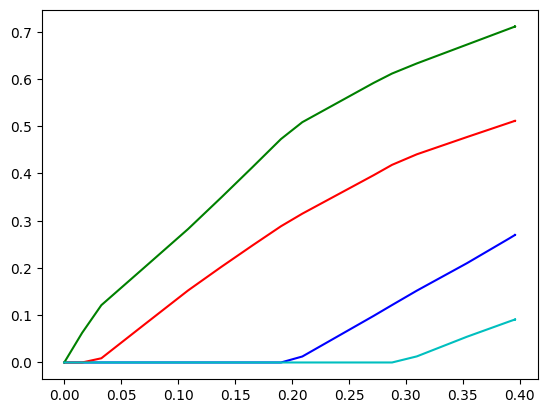

In [7]:
# training with original dataset X_orig
fig, ax = plt.subplots(num='advtrain_linf')
linfadvtrain = AdversarialTraining(X_orig, y, np.eye(X_orig.shape[1]), p=np.inf)
estimator = lambda X, y, a:  linfadvtrain(adv_radius=a)
alphas_adv, coefs_advtrain_linf  = get_path(X_orig, y, estimator, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf, ax)

100%|██████████| 200/200 [00:02<00:00, 84.25it/s]


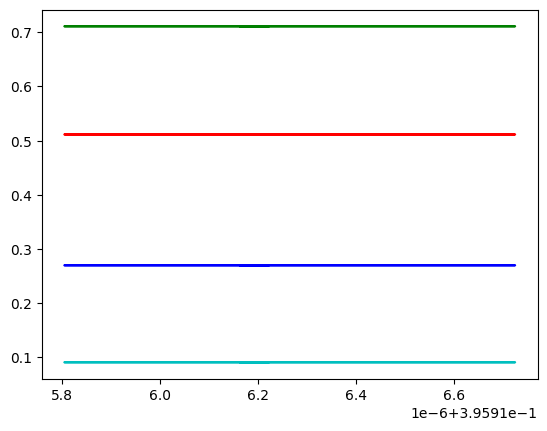

In [8]:
# training with original dataset X_orig
fig, ax = plt.subplots(num='advtrain_linf')
linfadvtrain = AdversarialTraining(X_orig, y, np.eye(X_orig.shape[1]) * 0.0001, p=np.inf)
estimator = lambda X, y, a:  linfadvtrain(adv_radius=a)
alphas_adv, coefs_advtrain_linf  = get_path(X_orig, y, estimator, 1e1)
#print("res ", coefs_advtrain_linf.T)
#print("alphas ", alphas_adv)
plot_coefs_l1norm(coefs_advtrain_linf, ax)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
100%|██████████| 200/200 [00:01<00:00, 133.16it/s]


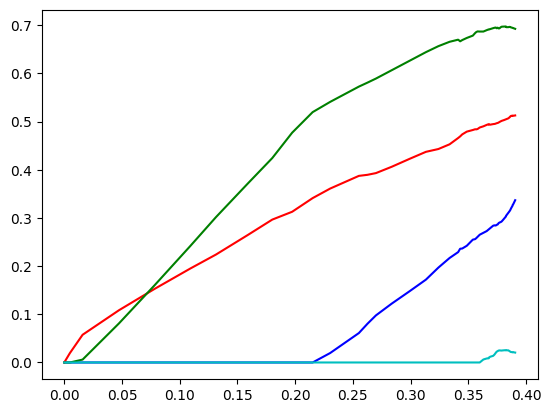

In [12]:
## random forest imputer
from sklearn.ensemble import RandomForestRegressor
rf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)

X_rf = single_imputation(X_nan, rf_estimator)
sd_rf = np.std(X_rf, axis=0)
S_inv_rf = np.diag(1 / sd_rf)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std rf\n ", sd_rf)
#print("S_inv std_rf \n", np.diag(1 / sd_rf))
#print("diag matr std \n", np.diag(sd_rf))
#print(X_orig)
#print(masks)
#print(X_rf)
fig, ax = plt.subplots(num='advtrain_linf_rf')
linfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)
estimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_rf, ax)


std_orig: 
 [0.99202252 1.11138638 0.96309324 0.95196366]
std rf
  [0.84217351 1.08286489 0.90736509 0.85669525]


100%|██████████| 200/200 [00:01<00:00, 147.92it/s]


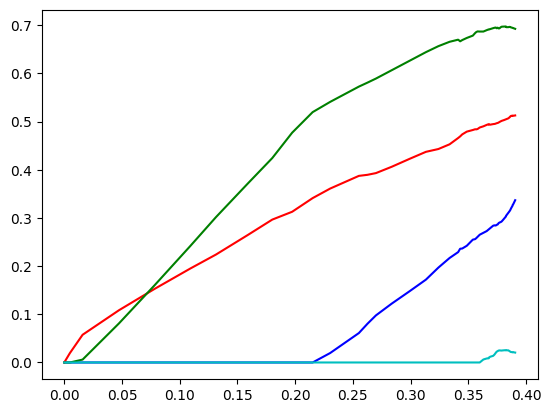

In [13]:
## iterative imputer Bayesian Ridge

from sklearn.linear_model import BayesianRidge
br_estimator = BayesianRidge()

X_br = single_imputation(X_nan, br_estimator)
sd_br = np.std(X_br, axis=0)
S_inv_br = np.diag(1 / sd_br)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std rf\n ", sd_br)
#print("S_inv std_rf \n", np.diag(1 / sd_rf))
#print("diag matr std \n", np.diag(sd_rf))
#print(X_orig)
#print(masks)
#print(X_rf)
fig, ax = plt.subplots(num='advtrain_linf_br')
linfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)
estimator_br = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_br, ax)



In [ ]:
## original lasso
fig, ax = plt.subplots(num='lasso')
alphas_lasso, coefs_lasso, _ = get_lasso_path(X_orig, y)
plot_coefs_l1norm(coefs_lasso, ax)

In [ ]:
# some simple tests
r = 4
S = np.random.randint(low=1, high=4, size=(r, r))
S = S.T @ S + np.eye(r)
print(S)
m = np.array([0, 0, 0, 1])  # 1 missing, 0 seen
m_bool = (m == 0)
print("m bool ", m_bool)
print(not m_bool.all())
S_sub = S[m_bool, :][:, m_bool]
print(S_sub)

S_ma = S[m_bool, :][:, ~m_bool]
print(S_ma)

s = np.array([1, 2, 3, 4])
ss = s
print(s[m_bool])

